Setup: Mount your Drive to the colab, so that it can access your kaggle.json API key. Make sure you have your kaggle.json in the root folder of your Drive. The code will then download the dataset into colab local storage.

NOTE: this storage will only last until the page is reloaded, so make sure to run this every time.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d lasaljaywardena/mobile-smartphone-images-dataset
! unzip mobile-smartphone-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: mobile_images/mobile_images/1635063616807_Samsung Galaxy Note 8 64GB Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063616967_Samsung Galaxy M21 Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063617163_Samsung Galaxy S7 Edge 64GB Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063617337_OnePlus 7T 8GB 128GB Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063617659_Xiaomi Redmi 7A Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063617885_Samsung Galaxy S8 64GB Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063618477_Samsung Galaxy A8 32GB Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063618817_Samsung Galaxy M31 Black 6GB 128GB Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063619201_Apple iPhone 6 Used for sale.jpg  
  inflating: mobile_images/mobile_images/1635063619997_Apple iPhone

Onto the actual code.

Let's try to keep all our imports at the top here.

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
from torch import nn
from PIL import Image

#This will let us reference attributes by name instead of remembering the position in the array
indexOf = {'fullName': 0, 'model': 1, 'brand': 2, 'condition': 3, 'filepath':4}

If you'd like to understand how the data looks, check out this code block, otherwise you can skip it

In [ ]:
mobile_data = pd.read_csv("/content/mobile_data_img.csv")

print("First Element:")
print(mobile_data.iloc[722])

print()
print("Brand of First Element:")
print(mobile_data.iloc[0][indexOf['brand']])

print()
print("Length of dataset:")
print(len(mobile_data))

First Element:
Label                sony xperia xzs 4gb ram/black ð¤ (used) 
Model                                                Xperia XZS
Brand                                                      Sony
Condition                                                  Used
Image_File    mobile_images/1635053000610_Sony Xperia XZS 4G...
Name: 722, dtype: object

Brand of First Element:
Apple

Length of dataset:
10200


Now for the dataloader. This has the optional input for a transform, so we can do any transform we need or decide to use.

In [ ]:
class MobilePhonesDataset(Dataset):

    #TODO: Split the data into train and test sets

    def __init__(self, data, root_dir="/content/mobile_images/", transform=None, train=0):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string, optional): Directory with all the images, this should not need to be manually set if I did it right.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = None

        i = 0
        for item in data.iloc:
            try:
                path = os.path.join(self.root_dir, item[indexOf['filepath']])
                image = Image.open(path)
            except (FileNotFoundError) as err:
                data = data.drop(i, axis=0)
            i = i + 1

        if(train == 0):
          self.data = data.iloc[:8000]
        elif (train == 1):
          self.data = data.iloc[8000:9000]
        elif (train == 2):
          self.data = data.iloc[9000:10000]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, indexOf['filepath']])

        #This makes the image grayscale
        image = Image.open(img_path).convert('L')
        brand = self.data.iloc[idx, indexOf['brand']]

        #TODO: test this, I imagine we'll need to change something here
        if self.transform:
            image = self.transform(image)

        brand = self.data.iloc[idx, indexOf['brand']]
        #reduce our dataset to just be apple or not apple
        if brand != 'Apple':
            label = torch.Tensor([1, 0])
        else:
            label = torch.Tensor([0, 1])

        #item = {'image': image, 'brand': brand}
        item = (image, label)
        return item

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

#randomize the csv for better sampling
data = pd.read_csv("/content/mobile_data_img.csv")
data.sample(frac=1)

trainData = MobilePhonesDataset(data, transform=transform, train=0)
trainLoader = DataLoader(trainData, batch_size=50)

devData = MobilePhonesDataset(data, transform=transform, train=1)
devLoader = DataLoader(devData, batch_size=50)

testData = MobilePhonesDataset(data, transform=transform, train=2)
testLoader = DataLoader(testData, batch_size=50)


Now that we have a Dataloader, we should be able to build a net and simply use the dataloader to pull our data.

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):

      super().__init__()
      self.conv_layers = nn.Sequential(
          nn.Conv2d(1, 6, 5),
          nn.ReLU(),
          nn.MaxPool2d(3),
          nn.Conv2d(6, 16, 5),
          nn.ReLU(),
          nn.MaxPool2d(3),
          nn.Conv2d(16,120,5),
          nn.ReLU(),
      )

      self.linear_layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(120, 2),
      )


    def forward(self, X):
        x = self.conv_layers(X)
        #What's this do?
        #x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

    def Train(self, trainData, n_iter, devData):

        for epoch in range(n_iter):
              num_correct = 0
              total_loss = 0.0
              self.train()   #Put the network into training mode
              for itr, (image, label) in enumerate(trainData):
                  #TODO: compute gradients, do parameter update, compute loss.
                  #label = torch.reshape(label, (1,2)).cuda()
                  label = label.cuda()

                  #Calculate loss
                  optimizer.zero_grad()
                  guess = self.forward(image).cuda()
                  crossEntropy = torch.nn.CrossEntropyLoss()
                  loss = crossEntropy(guess, label)
                  total_loss += loss

                  #backwards
                  loss.backward()
                  optimizer.step()

                  if itr % 40 == 0:
                    print(f"Train Epoch {epoch + 1}, {(itr/160)*100}%")

              lossPlot[epoch] = total_loss
              print(f"loss on epoch {epoch + 1} = {total_loss}")
              self.Eval(devData, epoch)
              print("------------------------------------------")
              pass

        pass

    def Eval(self, data, epoch=None):
        num_correct = 0
        for itr, (image, label) in enumerate(data):
          label = torch.argmax(label, dim=1).cuda()
          probs = self.forward(image).cuda()
          pred = torch.argmax(probs, dim=1).cuda()
          for i in range(len(label)):
            if label[i] == pred[i]:
              num_correct += 1

        acc = float(num_correct) / float(len(data) * data.batch_size)
        if epoch != None:
          accPlot[epoch] = acc
        print("Accuracy: %s" % (acc))
        pass

accPlot = np.zeros(20)
lossPlot = np.zeros(20)

simpleNet = SimpleNet()
optimizer = optim.Adam(simpleNet.parameters(), lr=0.0005)

simpleNet.Train(trainLoader, 20, devLoader)

Train Epoch 1, 0.0%
Train Epoch 1, 25.0%
Train Epoch 1, 50.0%
Train Epoch 1, 75.0%
loss on epoch 1 = 105.88097381591797
Accuracy: 0.614
------------------------------------------
Train Epoch 2, 0.0%
Train Epoch 2, 25.0%
Train Epoch 2, 50.0%
Train Epoch 2, 75.0%
loss on epoch 2 = 103.96563720703125
Accuracy: 0.618
------------------------------------------
Train Epoch 3, 0.0%
Train Epoch 3, 25.0%
Train Epoch 3, 50.0%
Train Epoch 3, 75.0%
loss on epoch 3 = 101.88681030273438
Accuracy: 0.625
------------------------------------------
Train Epoch 4, 0.0%
Train Epoch 4, 25.0%
Train Epoch 4, 50.0%
Train Epoch 4, 75.0%
loss on epoch 4 = 100.1279525756836
Accuracy: 0.624
------------------------------------------
Train Epoch 5, 0.0%
Train Epoch 5, 25.0%
Train Epoch 5, 50.0%
Train Epoch 5, 75.0%
loss on epoch 5 = 98.49739837646484
Accuracy: 0.619
------------------------------------------
Train Epoch 6, 0.0%
Train Epoch 6, 25.0%
Train Epoch 6, 50.0%
Train Epoch 6, 75.0%
loss on epoch 6 = 96.791

Now we check the accuracy against the test set and see how it did:

In [ ]:
simpleNet.Eval(testLoader)

Accuracy: 0.647


Finally, we plot the dev set accuracy and the loss for each epoch in training.

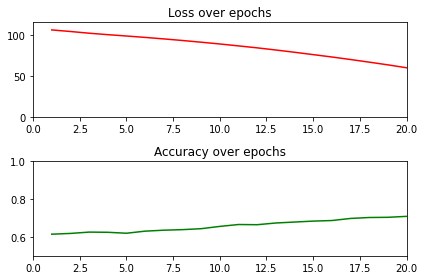

In [ ]:
x = np.arange(1,21)

#plot loss
plt.subplot(211)
plt.plot(x, lossPlot, 'r-')
plt.axis([0, 20, 0, 115])
plt.title("Loss over epochs")

#plot acc
plt.subplot(212)
plt.plot(x, accPlot, 'g-')
plt.axis([0, 20, .5, 1])
plt.title("Accuracy over epochs")

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.show()


Below this point is sample code for use in the code above.

In [ ]:
#PROJECT 3 NBOW PROVIDED AS EXAMPLE OF NET CODE

import tqdm
import torch
import torch.nn as nn
from torch import optim
import random
import numpy as np

class NBOW(nn.Module):
    def __init__(self, VOCAB_SIZE, DIM_EMB=300, NUM_CLASSES=2):
        super(NBOW, self).__init__()
        self.NUM_CLASSES=NUM_CLASSES
        #TODO: Initialize parameters.


    def forward(self, X):
        #TODO: Implement forward computation.


def EvalNet(data, net):
    num_correct = 0
    Y = (data.Y + 1.0) / 2.0
    X = data.XwordList
    for i in range(len(X)):
        logProbs = net.forward(X[i])
        pred = torch.argmax(logProbs)
        if pred == Y[i]:
            num_correct += 1
    print("Accuracy: %s" % (float(num_correct) / float(len(X))))

def SavePredictions(data, outFile, net):
    fOut = open(outFile, 'w')
    for i in range(len(data.XwordList)):
        logProbs = net.forward(data.XwordList[i])
        pred = torch.argmax(logProbs)
        fOut.write(f"{data.XfileList[i]}\t{pred}\n")

def Train(net, X, Y, n_iter, dev):
    print("Start Training!")
    #TODO: initialize optimizer.

    num_classes = len(set(Y))

    for epoch in range(n_iter):
        num_correct = 0
        total_loss = 0.0
        net.train()   #Put the network into training mode
        for i in tqdm.notebook.tqdm(range(len(X))):
            #TODO: compute gradients, do parameter update, compute loss.

            pass
        net.eval()    #Switch to eval mode
        print(f"loss on epoch {epoch} = {total_loss}")
        EvalNet(dev, net)


nbow = NBOW(train.vocab.GetVocabSize()).cuda()
Train(nbow, train.XwordList, (train.Y + 1.0) / 2.0, 10, dev)

In [ ]:
#VAGUE OUTLINE OF A NET

import torch
import torch.nn as nn


class SimpleNetFinal(nn.Module):
    def __init__(self):
        """
        Init function to define the layers and loss function
        Note: Use 'mean' reduction in the loss_criterion. Read Pytorch documention to understand what it means
        """
        super().__init__()

        self.conv_layers = nn.Sequential()
        self.fc_layers = nn.Sequential()
        self.loss_criterion = None

        #start important bit

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1,10,5),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(3, stride= 2),
            nn.ReLU(),
            nn.Conv2d(10,50,5),
            nn.MaxPool2d(3, stride= 2),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Conv2d(50,150,4),
            nn.BatchNorm2d(150),
            nn.MaxPool2d(3, stride= 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(150,300,4),
            nn.MaxPool2d(3, stride= 2, padding=1),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(300, 100),
            nn.Linear(100, 15)
        )

        self.loss_criterion = nn.CrossEntropyLoss()

        #end important bit

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass with the net
        Args:
        -   x: the input image [Dim: (N,C,H,W)]
        Returns:
        -   y: the output (raw scores) of the net [Dim: (N,15)]
        """
        model_output = None
        #begin important bit

        x = self.conv_layers(x)
        x = self.fc_layers(x)
        model_output = x

        #end important bit

        return model_output

In [ ]:
# resnet
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_data_resnet = MobilePhonesDataset(data, transform=transform, train=0)
train_data_resnet = DataLoader(train_data_resnet, batch_size=50)

dev_data_resnet = MobilePhonesDataset(data, transform=transform, train=1)
dev_data_resnet = DataLoader(dev_data_resnet, batch_size=50)

test_data_resnet = MobilePhonesDataset(data, transform=transform, train=2)
test_data_resnet = DataLoader(test_data_resnet, batch_size=50)


In [ ]:
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
entropy = nn.CrossEntropyLoss()
n_iter = 5
for epoch in range(n_iter):
  num_correct = 0
  total_loss = 0.0
  for itr, (image, label) in enumerate(trainData):
    #TODO: compute gradients, do parameter update, compute loss.
    #label = torch.reshape(label, (1,2)).cuda()
    label = label.cuda()

    #Calculate loss
    optimizer.zero_grad()
    guess = model(image).cuda()
    loss = entropy(guess, label)
    total_loss += float(loss)

    #backwards
    loss.backward()
    optimizer.step()

    if itr % 40 == 0:
      print(f"Train Epoch {epoch + 1}, {(itr/160)*100}%")
  print("Total Loss {}".format(total_loss))

RuntimeError: ignored